# annotAIte Pipeline Test

This notebook demonstrates the basic functionality of the annotAIte pipeline.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from annotAIte import run_falsecolor_pipeline
from skimage.io import imread
import matplotlib.pyplot as plt


/opt/homebrew/Caskroom/mambaforge/base/envs/ssbc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create or Load Test Image

You can either create a synthetic image or load your own.


In [12]:
# Option 1: Create synthetic test image
img = imread("honda.png")
img = imread("MALE159.jpg")
print(f"Image shape: {img.shape}")
print(f"Image dtype: {img.dtype}")
print(f"Image value range: [{img.min()}, {img.max()}]")

# Option 2: Load your own image (uncomment and adjust path)
# from PIL import Image
# img = np.array(Image.open("path/to/your/image.tif"))
# if img.ndim == 2:
#     img = np.stack([img, img, img], axis=-1)  # Convert grayscale to RGB


Image shape: (331, 504, 3)
Image dtype: uint8
Image value range: [24, 247]


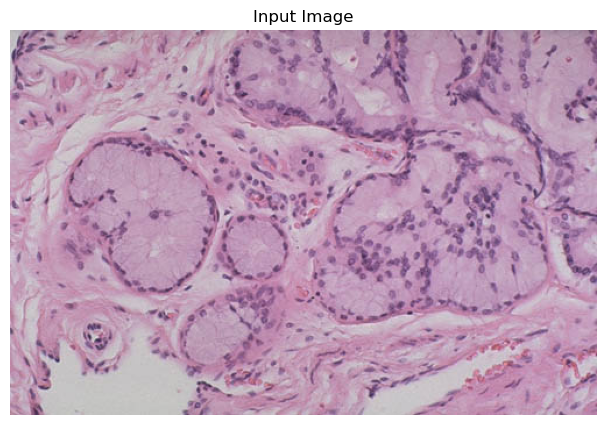

In [13]:
# Visualize input image
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.title("Input Image")
plt.axis("off")
plt.show()


## Run Pipeline

Execute the false-color mapping and clustering pipeline.


In [16]:
# Run pipeline with default parameters
result = run_falsecolor_pipeline(
    img=img,
    patch_size=11,
    stride=5,  # Overlapping patches
    gaussian_sigma=3.0,
    k=20,
    umap_neighbors=15,
    umap_min_dist=0.1,
    umap_random_state=None
)

print(f"False-color image shape: {result.falsecolor_img.shape}")
print(f"False-color image dtype: {result.falsecolor_img.dtype}")
print(f"False-color image range: [{result.falsecolor_img.min():.3f}, {result.falsecolor_img.max():.3f}]")
print(f"Cluster labels shape: {result.cluster_labels.shape}")
print(f"Cluster labels range: [{result.cluster_labels.min()}, {result.cluster_labels.max()}]")
print(f"Cluster centers shape: {result.centers.shape}")
print(f"Harmonization mapping: {result.mapping}")


False-color image shape: (331, 504, 3)
False-color image dtype: float32
False-color image range: [0.001, 0.997]
Cluster labels shape: (331, 504)
Cluster labels range: [0, 19]
Cluster centers shape: (20, 3)
Harmonization mapping: None


## Visualize Results


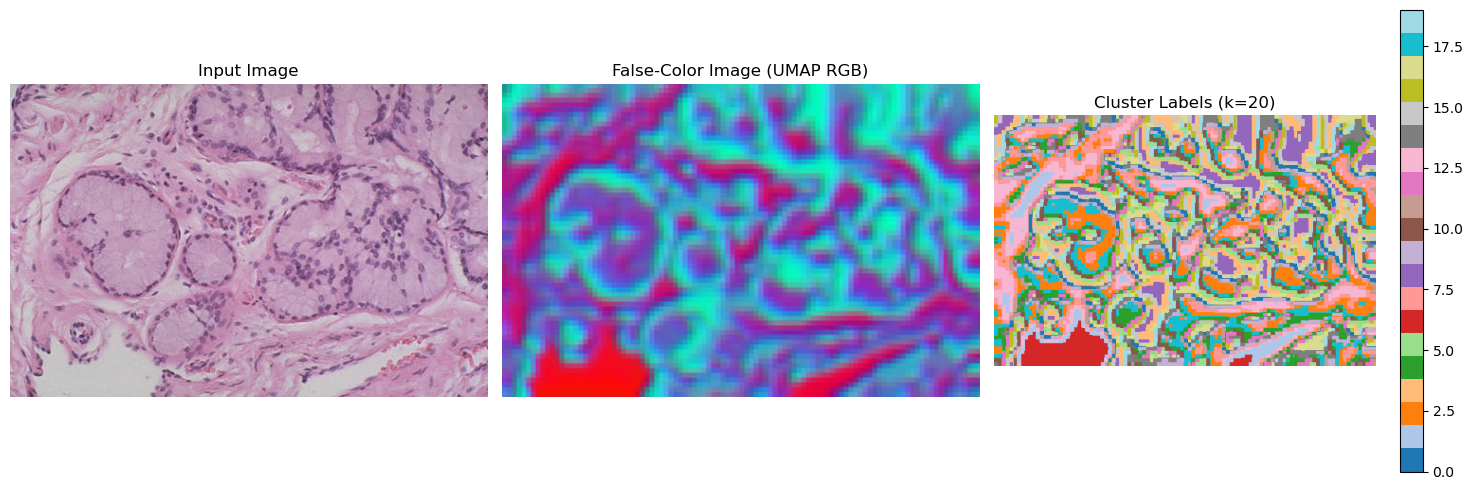

In [17]:
# Display false-color image and cluster labels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Input image
axes[0].imshow(img)
axes[0].set_title("Input Image")
axes[0].axis("off")

# False-color image
axes[1].imshow(result.falsecolor_img)
axes[1].set_title("False-Color Image (UMAP RGB)")
axes[1].axis("off")

# Cluster labels
im = axes[2].imshow(result.cluster_labels, cmap="tab20")
axes[2].set_title(f"Cluster Labels (k={result.centers.shape[0]})")
axes[2].axis("off")
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()


In [18]:
import napari
v = napari.Viewer()
_ = v.add_image(img)
_ = v.add_labels(result.cluster_labels+1)

In [23]:
from annotAIte import run_multi_scale_falsecolor, create_parameter_grid

# Option 1: Manual configuration list
configs = [
    {"patch_size": 5, "gaussian_sigma": 0.5},
    {"patch_size": 7, "gaussian_sigma": 1.0},
    {"patch_size": 11, "gaussian_sigma": 2.5},
]

# Option 2: Use helper to create grid
configs = create_parameter_grid(
    patch_sizes=[5, 7, 11],
    gaussian_sigmas=[1.5, 3.0, 7.5],
)

# Run multi-scale pipeline
result = run_multi_scale_falsecolor(
    img=img,
    parameter_configs=configs,
    final_k=20,  # Number of clusters for final k-means
    umap_max_patches=10000,
    umap_random_state=None
)

# Access individual false-color maps
for i, ind_result in enumerate(result.individual_results):
    falsecolor = ind_result.falsecolor_img  # (H, W, 3)
    labels = ind_result.cluster_labels      # (H, W)
    # Use for visualization/analysis

# Access final stacked representation and clustering
stacked = result.stacked_falsecolor  # (H, W, 9) if 3 configs
final_labels = result.final_labels   # (H, W)
final_centers = result.final_centers   # (10, 9)

In [24]:
for i in range(9):
    _ = v.add_image(stacked[:,:,i*3:i*3+3])

In [25]:
_ = v.add_labels(final_labels)

In [26]:
print(stacked.shape)

(331, 504, 27)


In [27]:
# Create a slightly different image (or use the same one)
# This simulates processing multiple images
img2 = img.copy()


# Run pipeline with harmonization
result2 = run_falsecolor_pipeline(
    img=img2,
    patch_size=11,
    stride=5,
    gaussian_sigma=1.0,
    k=10,
    ref_centers=result.centers,  # Harmonize to first result
    umap_random_state=None,
)

print(f"First run - cluster labels range: [{result.cluster_labels.min()}, {result.cluster_labels.max()}]")
print(f"Second run - cluster labels range: [{result2.cluster_labels.min()}, {result2.cluster_labels.max()}]")
print(f"Harmonization mapping: {result2.mapping}")


AttributeError: 'MultiScaleResult' object has no attribute 'centers'

In [ ]:
# Compare labels side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(result.cluster_labels, cmap="tab20")
axes[0].set_title("First Run (Reference)")
axes[0].axis("off")

axes[1].imshow(result2.cluster_labels, cmap="tab20")
axes[1].set_title("Second Run (Harmonized)")
axes[1].axis("off")

plt.tight_layout()
plt.show()
